# IQ-OTH/NCCD - Lung Cancer Dataset
Includes CT scans of patients diagnosed with Lung Cancer.



About
The Iraq-Oncology Teaching Hospital/National Center for Cancer Diseases (IQ-OTH/NCCD) lung cancer dataset was collected in the above-mentioned specialist hospitals over a period of three months in fall 2019. It includes CT scans of patients diagnosed with lung cancer in different stages, as well as healthy subjects. IQ-OTH/NCCD slides were marked by oncologists and radiologists in these two centers. The dataset contains a total of 1190 images representing CT scan slices of 110 cases (see Figure 1). These cases are grouped into three classes: normal, benign, and malignant. of these, 40 cases are diagnosed as malignant; 15 cases diagnosed with benign, and 55 cases classified as normal cases. The CT scans were originally collected in DICOM format. The scanner used is SOMATOM from Siemens. CT protocol includes: 120 kV, slice thickness of 1 mm, with window width ranging from 350 to 1200 HU a and window center from 50 to 600 were used for reading. with breath-hold at full inspiration. All images were de-identified before performing analysis. Written consent was waived by the oversight review board. The study was approved by the institutional review board of participating medical centers. Each scan contains several slices. The number of these slices range from 80 to 200 slices, each of them represents an image of the human chest with different sides and angles. The 110 cases vary in gender, age, educational attainment, area of residence, and living status. Some of them are employees of the Iraqi ministries of Transport and Oil, others are farmers and gainers. Most of them come from places in the middle region of Iraq, particularly, the provinces of Baghdad, Wasit, Diyala, Salahuddin, and Babylon.


In [39]:
# Usamos la carpeta local 'dataset'
from pathlib import Path

local_data_path = Path("dataset")

if local_data_path.exists():
    print(f"Usando dataset local en: {local_data_path.resolve()}")
else:
    print("ADVERTENCIA: No se encuentra la carpeta 'dataset' local.")

Usando dataset local en: C:\Users\pablo\Desktop\UV\DeepLearning\dataset


## Análisis Exploratorio de Datos (EDA)
Vamos a realizar un análisis simple para entender la estructura del dataset, contar las imágenes por clase y visualizar algunos ejemplos.

In [40]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configurar estilo de gráficas
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [41]:
# Definir el directorio del dataset
data_dir = Path("dataset")

print(f"Directorio del dataset: {data_dir}")

# Identificar las clases (subcarpetas)
# Buscamos subcarpetas que contengan imágenes
classes = [d.name for d in data_dir.iterdir() if d.is_dir()]
# Opcional: Filtrar 'Test' si solo nos interesan las clases etiquetadas
# classes = [c for c in classes if c != 'Test']
print(f"Clases encontradas: {classes}")

Directorio del dataset: dataset
Clases encontradas: ['Benign', 'Malignant', 'Normal', 'Test']


### 1. Distribución de las Clases
Primero, observemos cuántas imágenes tenemos para cada categoría. Un dataset desbalanceado puede requerir técnicas especiales durante el entrenamiento.

Cantidad de imágenes por clase: {'Benign': 120, 'Malignant': 561, 'Normal': 416, 'Test': 197}


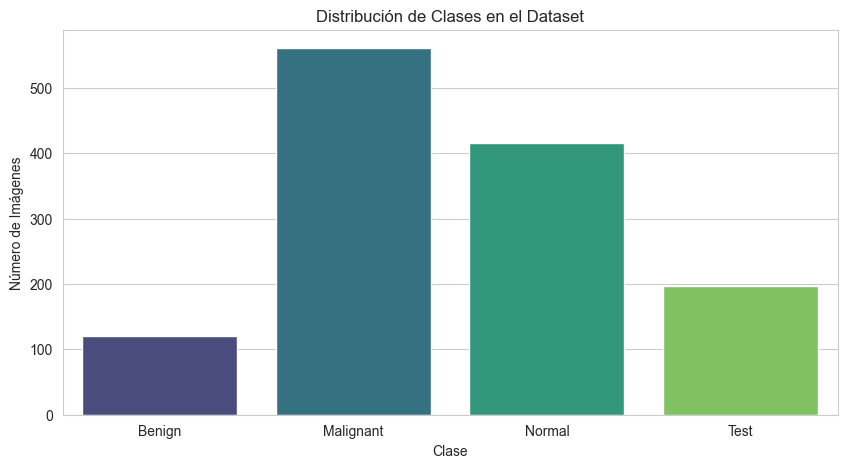

In [42]:
# Contar imágenes por clase
image_counts = {}
images_per_class = {}

for cls in classes:
    class_path = data_dir / cls
    # Buscar extensiones comunes de imágenes
    images = list(class_path.glob('*.jpg')) + list(class_path.glob('*.png')) + list(class_path.glob('*.jpeg'))
    image_counts[cls] = len(images)
    images_per_class[cls] = images

print("Cantidad de imágenes por clase:", image_counts)

# Visualizar la distribución
plt.figure(figsize=(10, 5))
sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()), palette='viridis', hue=list(image_counts.keys()), legend=False)
plt.title("Distribución de Clases en el Dataset")
plt.xlabel("Clase")
plt.ylabel("Número de Imágenes")
plt.show()

### 2. Visualización de Ejemplos
Es fundamental ver cómo lucen las imágenes. Esto nos ayuda a identificar si hay artefactos, ruido, o si necesitamos preprocesamiento adicional.

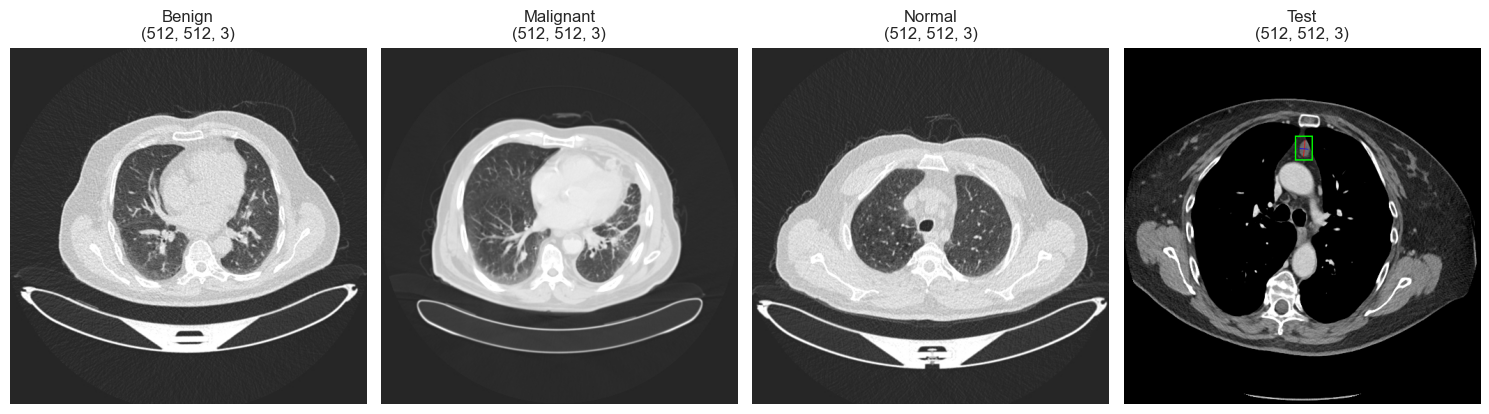

In [43]:
# Visualizar ejemplos de cada clase
n_classes = len(classes)
fig, axes = plt.subplots(1, n_classes, figsize=(15, 5))

if n_classes == 1:
    axes = [axes]

valid_images = []

for i, cls in enumerate(classes):
    if images_per_class[cls]:
        img_path = images_per_class[cls][0] # Tomamos la primera imagen
        img = cv2.imread(str(img_path))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            axes[i].imshow(img)
            axes[i].set_title(f"{cls}\n{img.shape}")
            axes[i].axis('off')
            valid_images.append(img_path)
        else:
             axes[i].text(0.5, 0.5, 'Error loading image', ha='center')
             axes[i].axis('off')
    else:
        axes[i].text(0.5, 0.5, 'No images', ha='center')
        axes[i].axis('off')

plt.tight_layout()
plt.show()

### 3. Análisis del Tamaño de las Imágenes
Para entrenar modelos de Deep Learning, generalmente necesitamos que todas las entradas tengan el mismo tamaño. Verifiquemos si las imágenes tienen dimensiones consistentes o si varían.

In [44]:
# Análisis de dimensiones de las imágenes
shapes = []
unique_shapes = set()

print("Analizando dimensiones de una muestra de imágenes...")

for cls in classes:
    # Muestreamos hasta 100 imágenes por clase para no tardar demasiado
    sample_images = images_per_class[cls][:100] 
    for img_path in sample_images:
        img = cv2.imread(str(img_path))
        if img is not None:
            shapes.append(img.shape)
            unique_shapes.add(img.shape)

if shapes:
    df_shapes = pd.DataFrame(shapes, columns=['Height', 'Width', 'Channels'])
    
    print(f"\nSe encontraron {len(unique_shapes)} tamaños únicos en la muestra:")
    for s in unique_shapes:
        print(f" - {s}")
        
    print("\nEstadísticas detalladas:")
    display(df_shapes.describe())
else:
    print("No se pudieron leer imágenes para el análisis de tamaño.")

Analizando dimensiones de una muestra de imágenes...

Se encontraron 3 tamaños únicos en la muestra:
 - (768, 768, 3)
 - (404, 511, 3)
 - (512, 512, 3)

Estadísticas detalladas:


,Height,Width,Channels
count,400.000000,400.00000,400.0
mean,513.650000,513.91750,3.0
std,22.787181,22.11489,0.0
min,404.000000,511.00000,3.0
25%,512.000000,512.00000,3.0
50%,512.000000,512.00000,3.0
75%,512.000000,512.00000,3.0
max,768.000000,768.00000,3.0


### Interpretación de las Estadísticas de Tamaño

La tabla anterior nos dice lo siguiente sobre las imágenes analizadas:

*   **Channels (Canales):** Todos los valores son **3**. Esto significa que todas las imágenes son **RGB** (Color).
*   **Mediana (50%):** Tanto para *Height* (Alto) como *Width* (Ancho) es **512**. Esto indica que la **gran mayoría de las imágenes son de 512x512 píxeles**.
*   **Min/Max:**
    *   La imagen más pequeña encontrada tiene 404 píxeles de alto.
    *   La más grande tiene 768x768 píxeles.

**Conclusión importante:** Aunque la mayoría son de 512x512, **hay variación en el tamaño**. Esto significa que antes de meter las imágenes a un modelo de Deep Learning, tendremos que hacer un **redimensionamiento (resize)** para que todas sean iguales (por ejemplo, forzar todas a 224x224 o 512x512).

In [45]:
# Vamos a ver exactamente cuántas NO son de 512x512
df_shapes = pd.DataFrame(shapes, columns=['Height', 'Width', 'Channels'])

standard_size = (512, 512)
non_standard = df_shapes[
    (df_shapes['Height'] != 512) | 
    (df_shapes['Width'] != 512)
]

print(f"Total de imágenes analizadas: {len(df_shapes)}")
print(f"Imágenes con tamaño estándar (512x512): {len(df_shapes) - len(non_standard)}")
print(f"Imágenes con tamaño DISTINTO: {len(non_standard)}")

if len(non_standard) > 0:
    print("\nAlgunos tamaños diferentes encontrados:")
    print(non_standard.groupby(['Height', 'Width']).size())

Total de imágenes analizadas: 400
Imágenes con tamaño estándar (512x512): 396
Imágenes con tamaño DISTINTO: 4

Algunos tamaños diferentes encontrados:
Height  Width
404     511      1
768     768      3
dtype: int64


### 4. Análisis de Intensidad de Píxeles
Vamos a analizar la distribución de los valores de los píxeles. Esto nos dirá si las imágenes son muy oscuras, muy claras, o si tienen buen contraste. También comprobaremos si, a pesar de tener 3 canales, son realmente imágenes en blanco y negro (escala de grises).

Calculando histograma de intensidades (esto puede tardar unos segundos)...

Análisis de Canales de Color: Las imágenes tienen información de color diferente en los canales
Valor promedio de píxel: 100.58
Desviación estándar: 76.99
Valor mínimo: 0
Valor máximo: 255


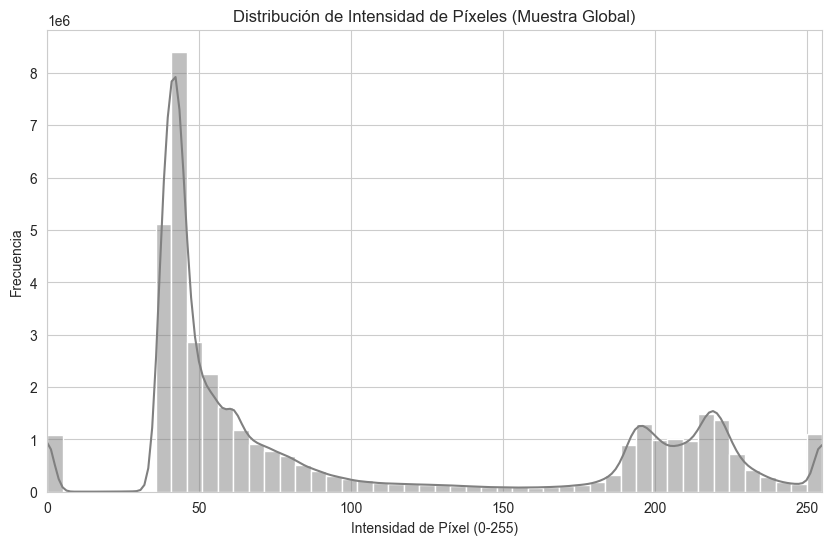

In [46]:
# Función para analizar una imagen
def analyze_pixel_intensity(files_list, n_samples=100):
    pixel_values = []
    is_grayscale = True
    
    # Tomamos una muestra aleatoria si hay muchas imágenes
    import random
    sample_files = random.sample(files_list, min(len(files_list), n_samples))
    
    for img_path in sample_files:
        img = cv2.imread(str(img_path))
        if img is not None:
            # Aplanar la imagen para tener todos los píxeles en una sola lista
            pixel_values.extend(img.flatten())
            
            # Chequear si R=G=B (escala de grises guardada como RGB)
            # Solo chequeamos la primera imagen válida para no tardar mucho o un par de ellas
            if is_grayscale:
                b, g, r = cv2.split(img)
                if not (np.array_equal(b, g) and np.array_equal(g, r)):
                    is_grayscale = False

    return np.array(pixel_values), is_grayscale

# Recopilar todas las imágenes
all_images = []
for cls_images in images_per_class.values():
    all_images.extend(cls_images)

print("Calculando histograma de intensidades (esto puede tardar unos segundos)...")
pixels, grayscale_check = analyze_pixel_intensity(all_images, n_samples=50)

print(f"\nAnálisis de Canales de Color: {'Las imágenes parecen ser escala de grises (R=G=B)' if grayscale_check else 'Las imágenes tienen información de color diferente en los canales'}")
print(f"Valor promedio de píxel: {pixels.mean():.2f}")
print(f"Desviación estándar: {pixels.std():.2f}")
print(f"Valor mínimo: {pixels.min()}")
print(f"Valor máximo: {pixels.max()}")

# Graficar histograma
plt.figure(figsize=(10, 6))
sns.histplot(pixels, bins=50, color='gray', kde=True)
plt.title("Distribución de Intensidad de Píxeles (Muestra Global)")
plt.xlabel("Intensidad de Píxel (0-255)")
plt.ylabel("Frecuencia")
plt.xlim(0, 255)
plt.show()

## 5. Preparación de los Datos (Data Splitting)
### Importante: Sobre el conjunto de 'Test' original
La carpeta `Test` original del dataset contiene imágenes con nombres sugestivos pero **sin etiquetas de clase** explícitas (están en una carpeta única). Por ello, no se pueden usar para validación supervisada.

**Estrategia:**
Ignoramos la carpeta `Test` original y dividimos las imágenes etiquetadas (`Benign`, `Malignant`, `Normal`) en: 
*   **Train (70%)**
*   **Validation (15%)**
*   **Test (15%)**

In [63]:
from sklearn.model_selection import train_test_split

# 1. Recopilar rutas y etiquetas
filepaths = []
labels = []
valid_classes = ['Benign', 'Malignant', 'Normal']

for cls in valid_classes:
    if cls in images_per_class:
        imgs = images_per_class[cls]
        filepaths.extend(imgs)
        labels.extend([cls] * len(imgs))

df = pd.DataFrame({'filepath': filepaths, 'label': labels})
print(f"Total de imágenes etiquetadas: {len(df)}")

# 2. Split Estratificado
# Train 70%, Rest 30%
train_df, rest_df = train_test_split(df, test_size=0.3, shuffle=True, random_state=42, stratify=df['label'])
# Validation 50% of Rest (15% total), Test 50% of Rest (15% total)
val_df, test_df = train_test_split(rest_df, test_size=0.5, shuffle=True, random_state=42, stratify=rest_df['label'])

print(f"\nTrain:       {len(train_df)} ({len(train_df)/len(df):.1%})")
print(f"Validation:  {len(val_df)} ({len(val_df)/len(df):.1%})")
print(f"Test:        {len(test_df)} ({len(test_df)/len(df):.1%})")

# Calcular porcentajes de Normales en cada conjunto
train_normal_pct = (train_df['label'] == 'Normal').sum() / len(train_df) * 100
val_normal_pct = (val_df['label'] == 'Normal').sum() / len(val_df) * 100
test_normal_pct = (test_df['label'] == 'Normal').sum() / len(test_df) * 100



# Calcular porcentajes de Benignos en cada conjunto
train_benign_pct = (train_df['label'] == 'Benign').sum() / len(train_df) * 100
val_benign_pct = (val_df['label'] == 'Benign').sum() / len(val_df) * 100
test_benign_pct = (test_df['label'] == 'Benign').sum() / len(test_df) * 100

# Calcular porcentajes de Normales en cada conjunto

train_malignant_pct = (train_df['label'] == 'Malignant').sum() / len(train_df) * 100
val_malignant_pct = (val_df['label'] == 'Malignant').sum() / len(val_df) * 100
test_malignant_pct = (test_df['label'] == 'Malignant').sum() / len(test_df) * 100



print("\n=== Distribución en Train ===")
print(train_df['label'].value_counts())
print(f"Porcentaje de Normales:   {train_normal_pct:.2f}%")
print(f"Porcentaje de Benignos:   {train_benign_pct:.2f}%")
print(f"Porcentaje de Malignos:   {train_malignant_pct:.2f}%")

print("\n=== Distribución en Validation ===")
print(val_df['label'].value_counts())
print(f"Porcentaje de Normales:   {val_normal_pct:.2f}%")
print(f"Porcentaje de Benignos:   {val_benign_pct:.2f}%")
print(f"Porcentaje de Malignos:   {val_malignant_pct:.2f}%")

print("\n=== Distribución en Test ===")
print(test_df['label'].value_counts())
print(f"Porcentaje de Normales:   {test_normal_pct:.2f}%")
print(f"Porcentaje de Benignos:   {test_benign_pct:.2f}%")
print(f"Porcentaje de Malignos:   {test_malignant_pct:.2f}%")


Total de imágenes etiquetadas: 1097

Train:       767 (69.9%)
Validation:  165 (15.0%)
Test:        165 (15.0%)

=== Distribución en Train ===
label
Malignant    392
Normal       291
Benign        84
Name: count, dtype: int64
Porcentaje de Normales:   37.94%
Porcentaje de Benignos:   10.95%
Porcentaje de Malignos:   51.11%

=== Distribución en Validation ===
label
Malignant    84
Normal       63
Benign       18
Name: count, dtype: int64
Porcentaje de Normales:   38.18%
Porcentaje de Benignos:   10.91%
Porcentaje de Malignos:   50.91%

=== Distribución en Test ===
label
Malignant    85
Normal       62
Benign       18
Name: count, dtype: int64
Porcentaje de Normales:   37.58%
Porcentaje de Benignos:   10.91%
Porcentaje de Malignos:   51.52%


Las proporciones se mantienen, así que el proximo paso lógico será hacer un baseline con los datos crudos, luego normalizarlos(preferiblemente entre 0 y 1), luego uno con los datos con DA para balencar clases y por último empezar a meter más cosas.